In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
from tensorflow import keras
import matplotlib as mpl
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler

In [2]:
# load data

In [3]:
month = pd.read_csv("Month_Value_1.csv")
month.head()

,Period,Revenue,Sales_quantity,Average_cost,The_average_annual_payroll_of_the_region
0,01.01.2015,1.601007e+07,12729.0,1257.763541,30024676.0
1,01.02.2015,1.580759e+07,11636.0,1358.507000,30024676.0
2,01.03.2015,2.204715e+07,15922.0,1384.697024,30024676.0
3,01.04.2015,1.881458e+07,15227.0,1235.606705,30024676.0
4,01.05.2015,1.402148e+07,8620.0,1626.621765,30024676.0


In [4]:
# Checking for null values
month.isnull().sum()

Period                                       0
Revenue                                     32
Sales_quantity                              32
Average_cost                                32
The_average_annual_payroll_of_the_region    32
dtype: int64

In [5]:
# Deleting the NULL values
month = month.dropna(subset = ['Revenue'])

In [6]:
# Checking for null values
month.isnull().sum()

Period                                      0
Revenue                                     0
Sales_quantity                              0
Average_cost                                0
The_average_annual_payroll_of_the_region    0
dtype: int64

In [7]:
month.columns

Index(['Period', 'Revenue', 'Sales_quantity', 'Average_cost',
       'The_average_annual_payroll_of_the_region'],
      dtype='object')

In [8]:
month.drop(['Sales_quantity', 'Average_cost',
       'The_average_annual_payroll_of_the_region'], axis = 1, inplace = True)

In [9]:
month.head()

,Period,Revenue
0,01.01.2015,1.601007e+07
1,01.02.2015,1.580759e+07
2,01.03.2015,2.204715e+07
3,01.04.2015,1.881458e+07
4,01.05.2015,1.402148e+07


In [10]:
#renaming columns
month.rename(columns={"Revenue": "value"}, inplace = True)
month.rename(columns={"Period": "date"}, inplace = True)
month.head(3)

,date,value
0,01.01.2015,1.601007e+07
1,01.02.2015,1.580759e+07
2,01.03.2015,2.204715e+07


In [11]:
# Converting date to actual datetime
month['date'] = pd.to_datetime(month['date'])

<Axes: xlabel='date', ylabel='value'>

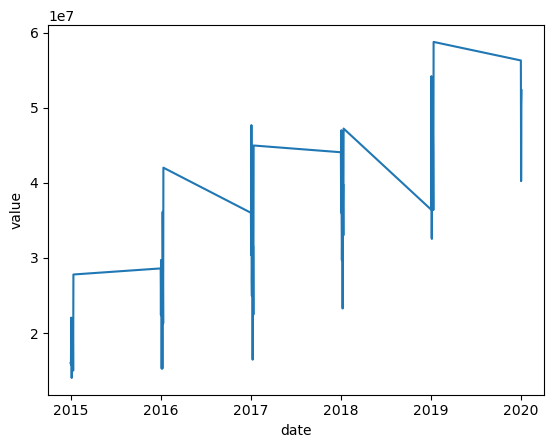

In [12]:
# plot/visualise data and value
sns.lineplot(x='date', y='value', data=month)

In [13]:
# Function to convert the dataset to a timeseries (specific for datasets with only the target column used)
def create_window(target, window=1, offset=0):
    feature_new, target_new = [], []
    # Convert our series to a numpy array
    target_np = target.to_numpy()
    for index in range(window, target.shape[0] - offset):
        feature_new.append(target_np[index - window: index])
        target_new.append(target_np[index+offset])
    return np.array(feature_new), np.array(target_new)


In [16]:
month = month.sort_values(by=['date'])
window = 5
feature, target = create_window(month['value'], window=window)
print(feature[0])
print(target[0])
print(month.head(6))

[16010072.1195   15807587.449808 22047146.023644 18814583.29428
 14021479.611678]
16783928.522112
        date         value
0 2015-01-01  1.601007e+07
1 2015-01-02  1.580759e+07
2 2015-01-03  2.204715e+07
3 2015-01-04  1.881458e+07
4 2015-01-05  1.402148e+07
5 2015-01-06  1.678393e+07


In [17]:
# Scaling the values of feature
scaler_feature = StandardScaler()
feature_shape = feature.shape
feature_scaled = scaler_feature.fit_transform(feature)
feature_scaled[0]

array([-1.42051939, -1.44976653, -0.91290389, -1.23656311, -1.70646632])

In [18]:
# Scaling the values of target
scaler_target = StandardScaler()
target_scaled = scaler_target.fit_transform(target.reshape(-1,1))
target_scaled[0: 5]

array([[-1.51738733],
       [-1.30323812],
       [-1.65958028],
       [-1.17337347],
       [-1.13834767]])

In [20]:
# split the dataset in train and test

In [21]:
def train_test(feature, target, perc_train = 0.8):
    size_train = int(len(feature) * perc_train)

    x_train = feature[0:size_train]
    y_train = target[0:size_train]

    x_test = feature[size_train: len(feature)]
    y_test = target[size_train: len(feature)]

    return x_train, x_test, y_train, y_test

x_train, x_test, y_train, y_test = train_test(feature_scaled, target_scaled)

Text(0.5, 0, 'Date')

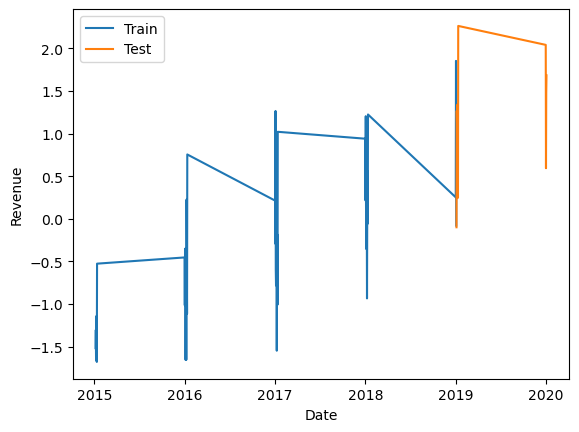

In [22]:
sns.lineplot(x=month['date'].iloc[window:len(y_train) + window], y=y_train[:,0], label='Train')
sns.lineplot(x=month['date'].iloc[len(y_train) + window:], y=y_test[:,0], label='Test')
plt.ylabel('Revenue')
plt.xlabel('Date')

In [23]:
# Regression

In [24]:
# Neural Network (LSTM)

In [25]:
# Reshaping the feature values to use them on the LSTM layer from keras
x_train, x_test = x_train.reshape(-1,window,1), x_test.reshape(-1,window,1)

model = keras.Sequential()
model.add(keras.layers.LSTM(128, input_shape=(x_train.shape[1], x_train.shape[2])))
model.add(keras.layers.Dense(units=1))

model.compile(loss='mean_squared_error', optimizer='RMSProp')
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 128)               66560     
                                                                 
 dense (Dense)               (None, 1)                 129       
                                                                 
Total params: 66689 (260.50 KB)
Trainable params: 66689 (260.50 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [26]:
result = model.fit(x_train,y_train,validation_data=(x_test,y_test),epochs=10)

Epoch 1/10
2/2 [==============================] - 1s 163ms/step - loss: 0.7551 - val_loss: 1.2625
Epoch 2/10
2/2 [==============================] - 0s 12ms/step - loss: 0.6024 - val_loss: 1.0398
Epoch 3/10
2/2 [==============================] - 0s 11ms/step - loss: 0.5616 - val_loss: 0.9849
Epoch 4/10
2/2 [==============================] - 0s 13ms/step - loss: 0.5569 - val_loss: 1.0044
Epoch 5/10
2/2 [==============================] - 0s 11ms/step - loss: 0.5558 - val_loss: 1.0328
Epoch 6/10
2/2 [==============================] - 0s 10ms/step - loss: 0.5455 - val_loss: 1.0067
Epoch 7/10
2/2 [==============================] - 0s 9ms/step - loss: 0.5377 - val_loss: 0.9973
Epoch 8/10
2/2 [==============================] - 0s 9ms/step - loss: 0.5397 - val_loss: 1.0366
Epoch 9/10
2/2 [==============================] - 0s 10ms/step - loss: 0.5432 - val_loss: 1.0334
Epoch 10/10
2/2 [==============================] - 0s 10ms/step - loss: 0.5384 - val_loss: 1.0460


Text(0, 0.5, 'Cost')

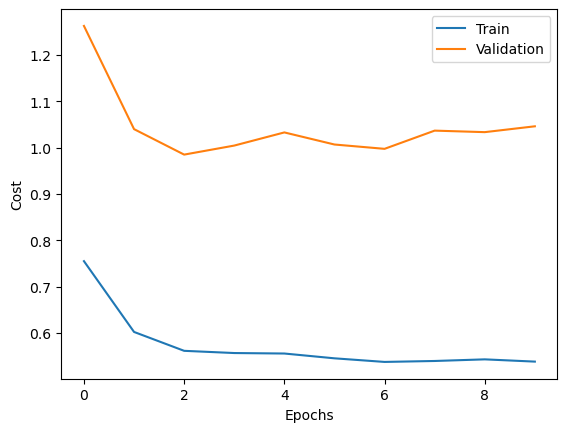

In [27]:
plt.plot(result.history['loss'])
plt.plot(result.history['val_loss'])
plt.legend(['Train', 'Validation'])
plt.xlabel('Epochs')
plt.ylabel('Cost')

In [28]:
# Function to print the charts comparing the original dataset with the predicted values
def results_chart(y_predicted, y_test, y_train, x_date, window):
    grid = plt.figure(figsize=(17,20))

    g1 = grid.add_subplot(2,1,1)
    g2 = grid.add_subplot(2,1,2)

    sns.lineplot(x=x_date[window:len(y_train) + window], y=y_train[:,0], label='Train', ax=g1)
    sns.lineplot(x=x_date[len(y_train) + window:], y=y_test[:,0], label='Test', ax=g1)
    sns.lineplot(x=x_date[len(y_train) + window:], y=y_predicted[:,0], label='Predicted', ax=g1)
    g1.set_title('Train x Test x Predict')

    sns.lineplot(x=x_date[len(y_train) + window:], y=y_test[:,0], label='Test', ax=g2)
    sns.lineplot(x=x_date[len(y_train) + window:], y=y_predicted[:,0], label='Predicted', ax=g2)
    g2.set_title('Test x Predict')


1/1 [==============================] - 0s 11ms/step


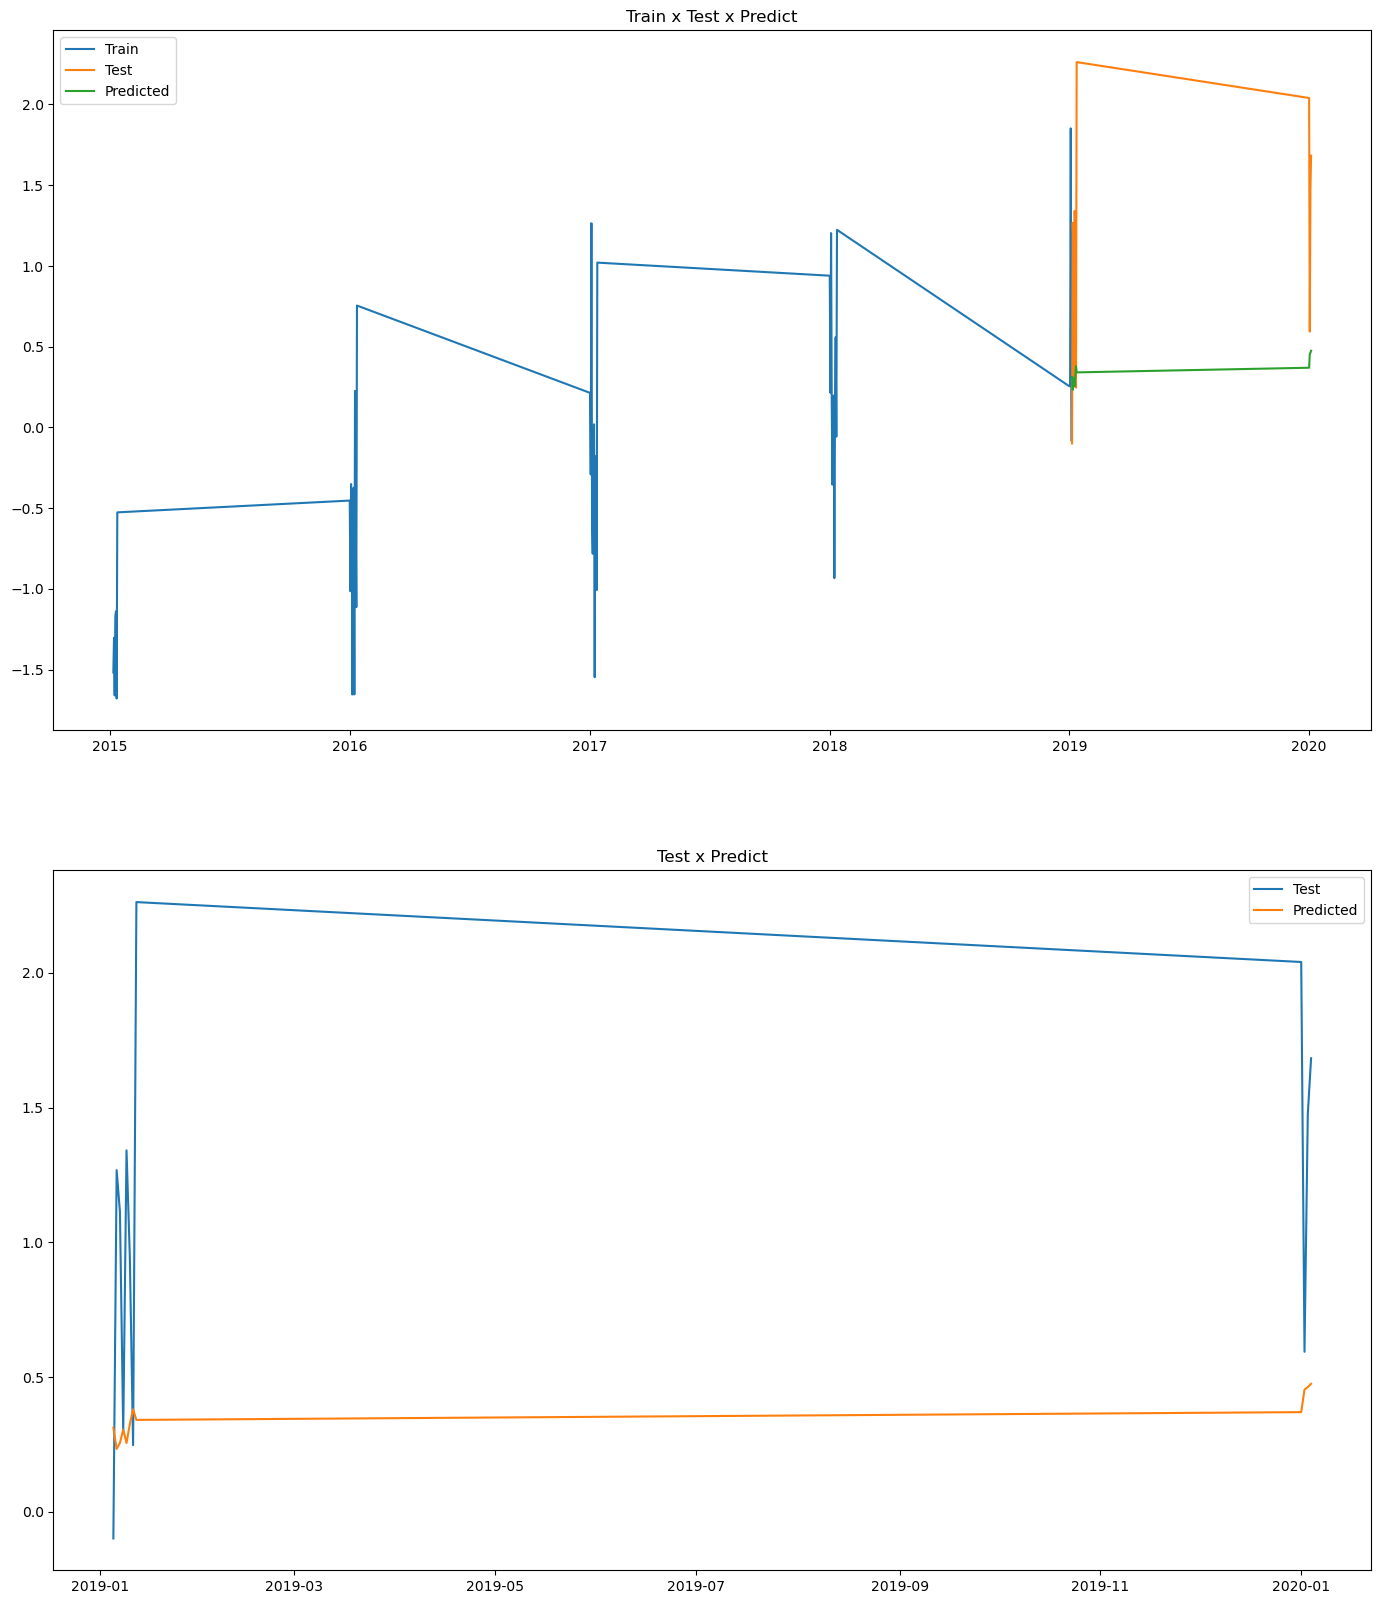

In [30]:
y_predicted = model.predict(x_test)

results_chart(y_predicted, y_test, y_train, month['date'].to_numpy(), window)

In [31]:
# Linear Regression

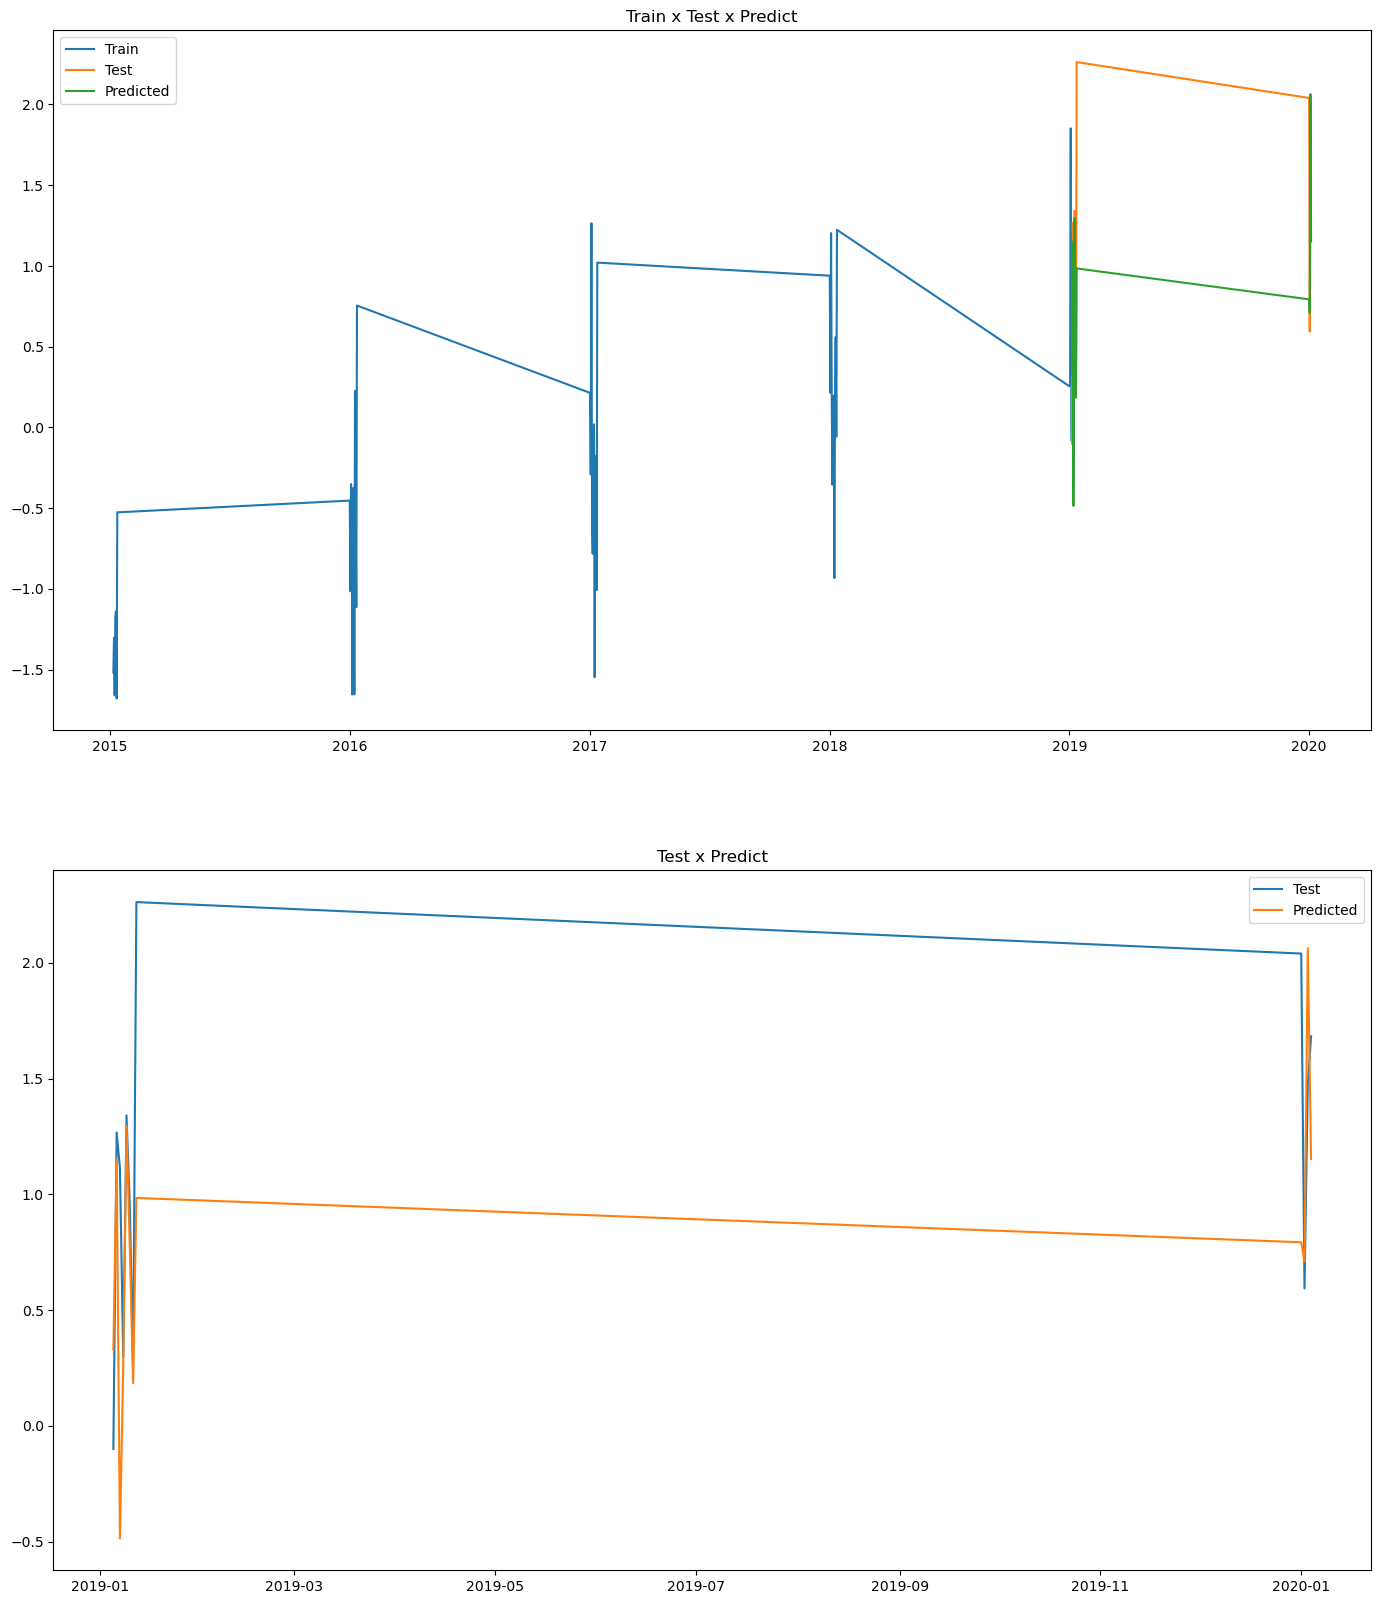

In [32]:
from sklearn.linear_model import LinearRegression

model_linear_reg = LinearRegression().fit(x_train.reshape(-1,window), y_train)
y_predicted = model_linear_reg.predict(x_test.reshape(-1,window))

results_chart(y_predicted, y_test, y_train, month['date'].to_numpy(), window)

In [33]:
# SVR

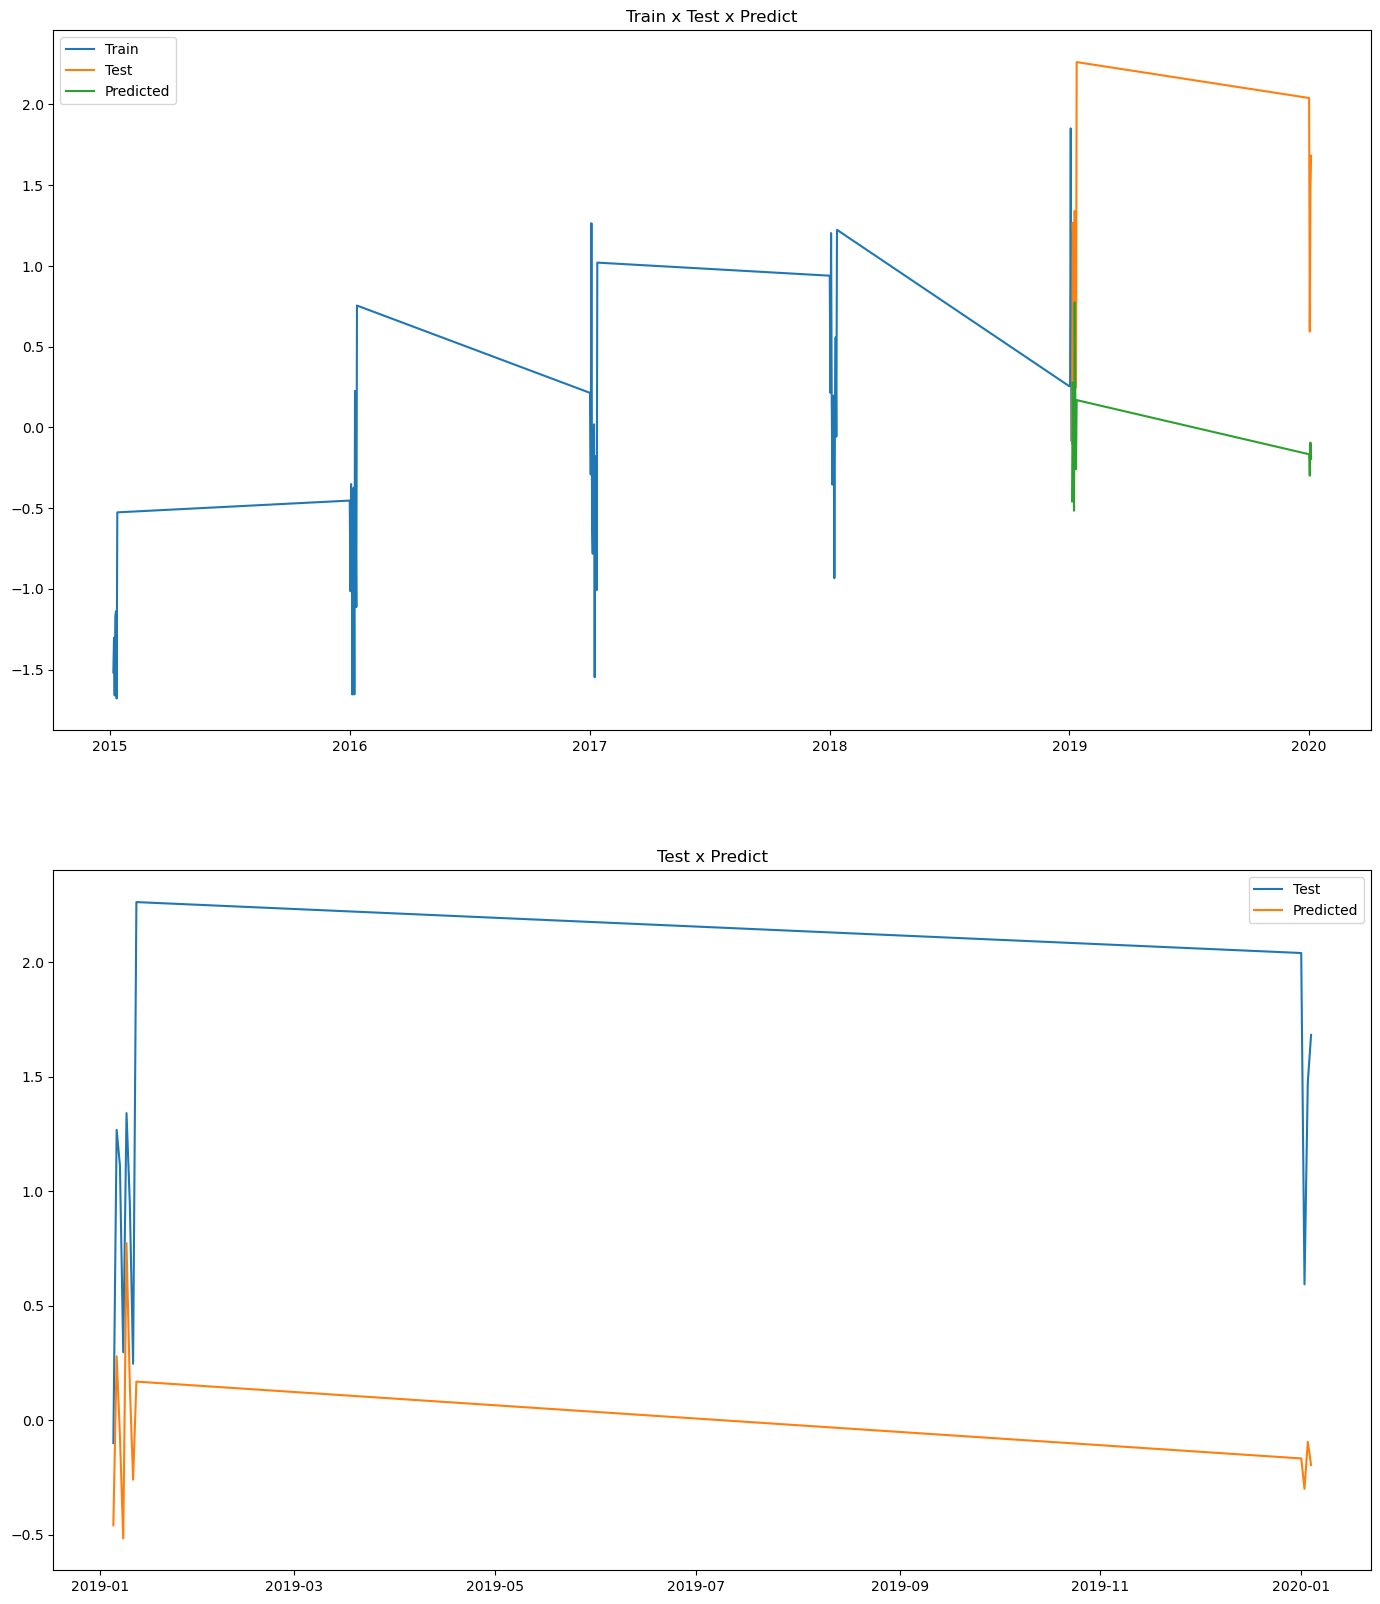

In [34]:
from sklearn.svm import SVR

model_svr = SVR().fit(x_train.reshape(-1,window), y_train.reshape(-1))
y_predicted = model_svr.predict(x_test.reshape(-1,window)).reshape(-1,1)

results_chart(y_predicted, y_test, y_train, month['date'].to_numpy(), window)

In [35]:
# SGD Regressor

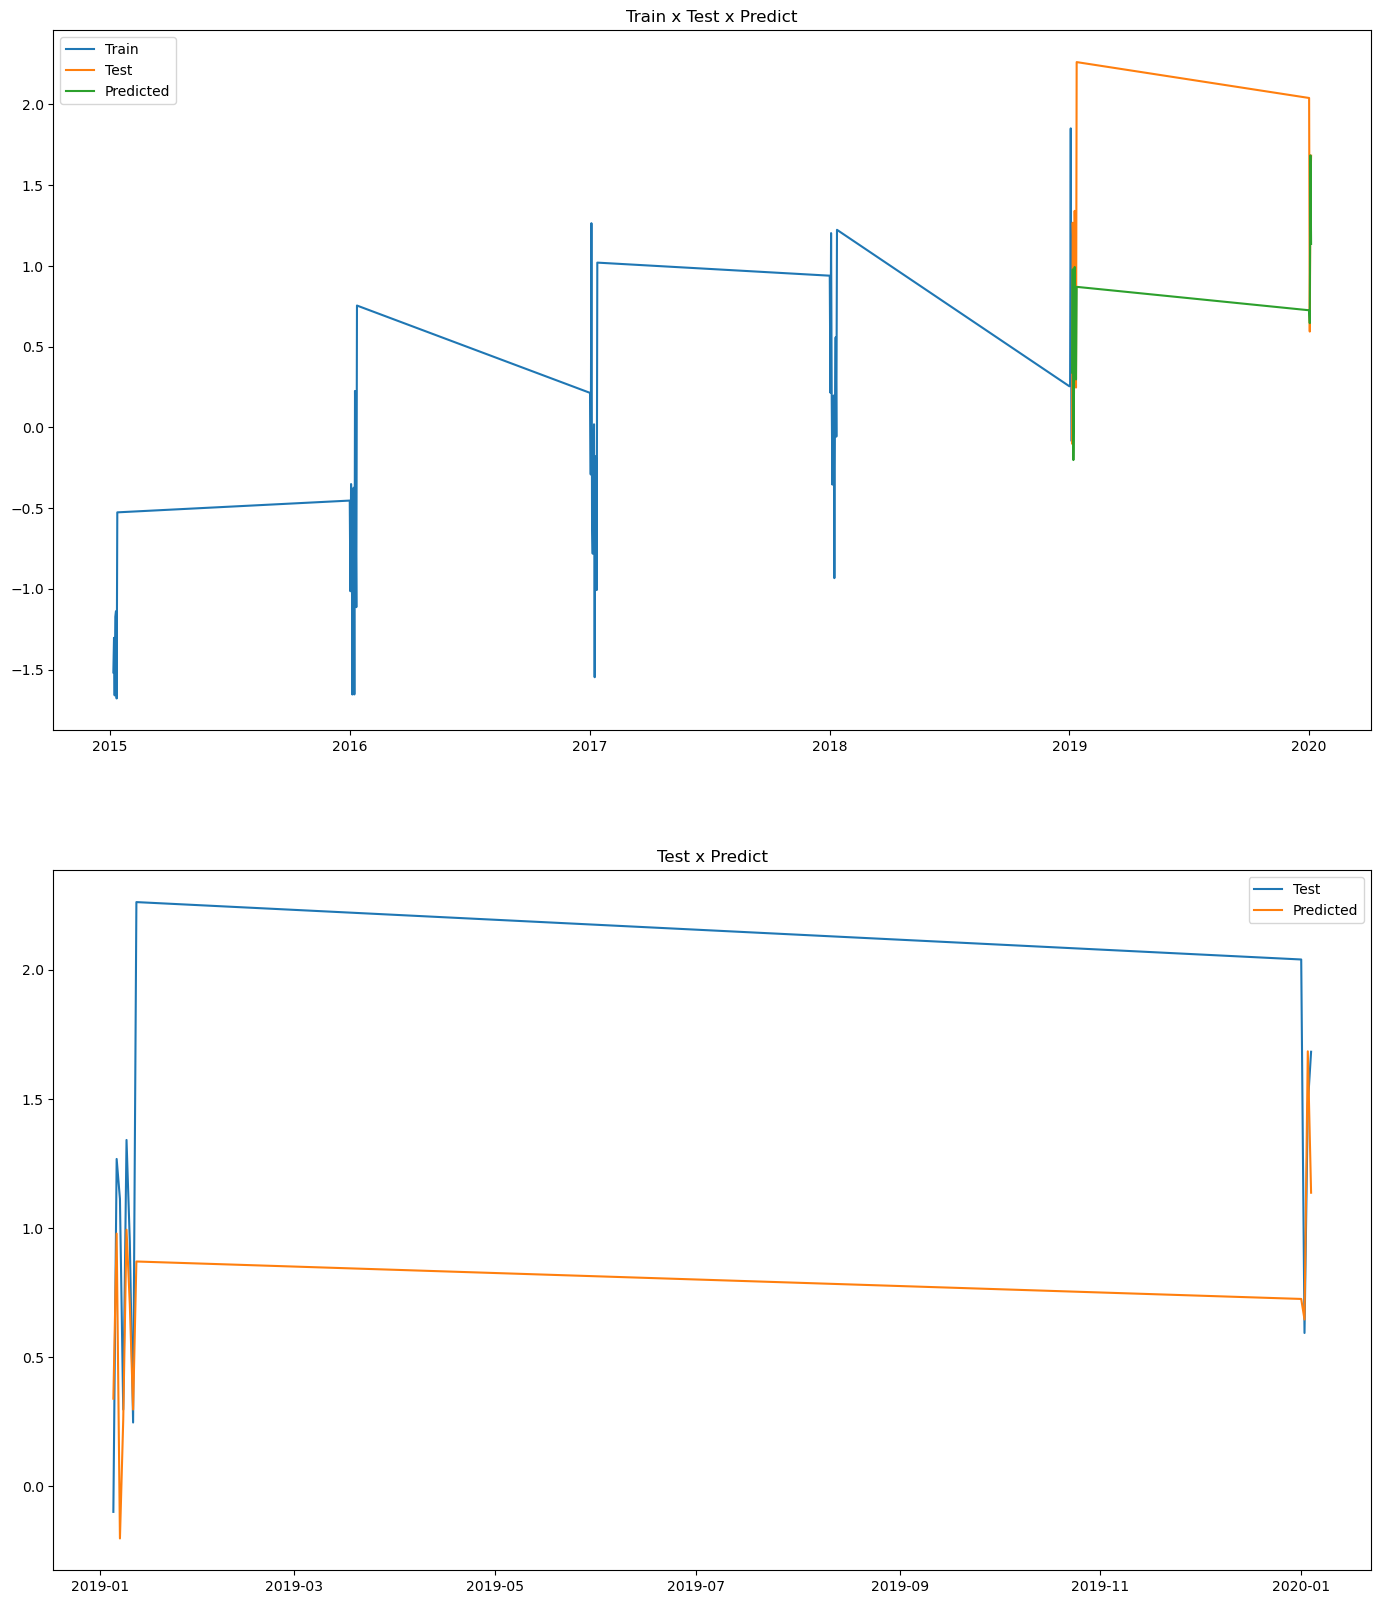

In [36]:
from sklearn.linear_model import SGDRegressor

model_sdgr = SGDRegressor().fit(x_train.reshape(-1,window), y_train.reshape(-1))
y_predicted = model_sdgr.predict(x_test.reshape(-1,window)).reshape(-1,1)

results_chart(y_predicted, y_test, y_train, month['date'].to_numpy(), window)

In [37]:
# Decision Tree Regressor

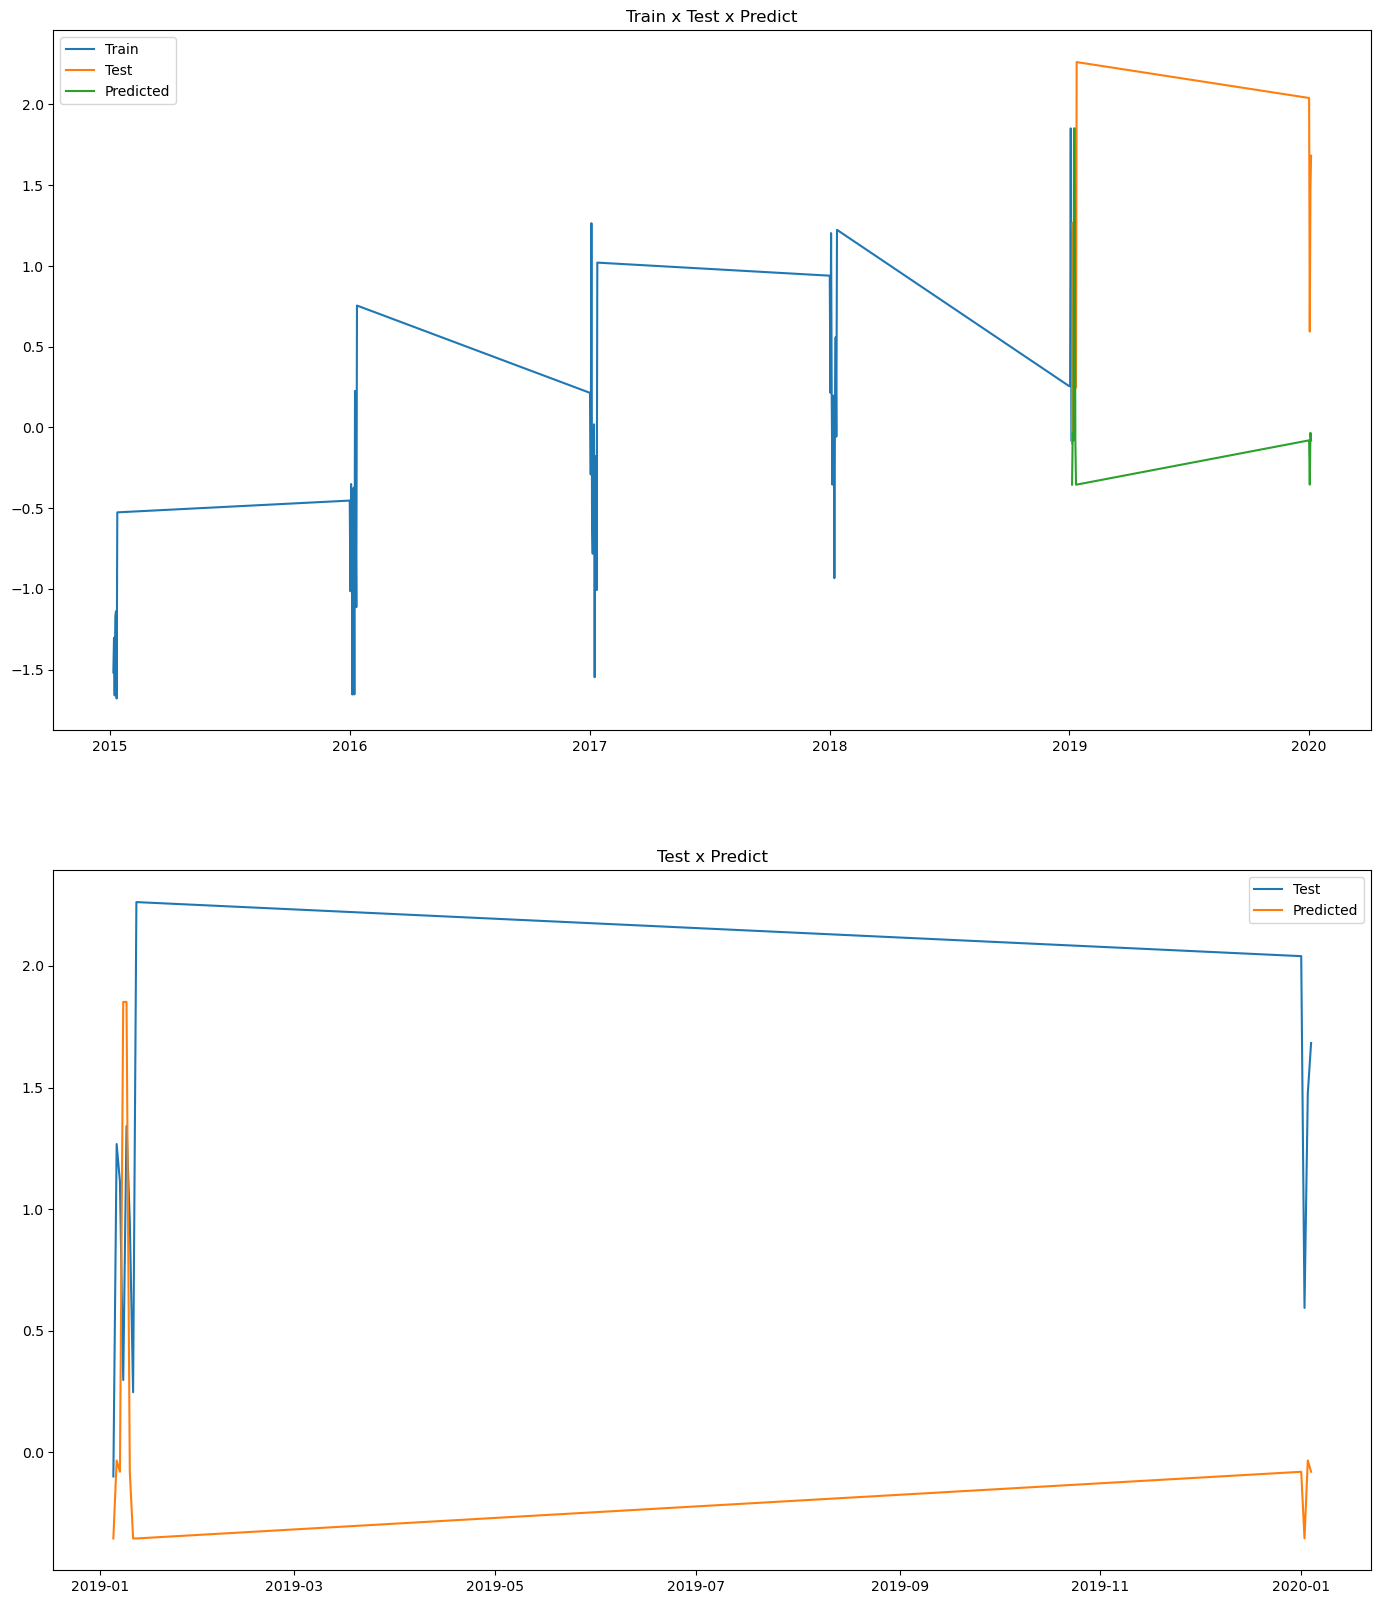

In [38]:
from sklearn.tree import DecisionTreeRegressor

model_decision_tree = DecisionTreeRegressor().fit(x_train.reshape(-1,window), y_train.reshape(-1))
y_predicted = model_decision_tree.predict(x_test.reshape(-1,window)).reshape(-1,1)

results_chart(y_predicted, y_test, y_train, month['date'].to_numpy(), window)

In [39]:
# Predicting the future

In [40]:
# Function specific for the lst because of the type of shape
def predict_future_lstm(target, model, window, n=100):
    new_target = target.tolist()
    for i in range(n):
        feature = np.array(new_target[-window:]).reshape(1,window,1)
        target_predicted = model.predict(feature).reshape(1)
        new_target.append(target_predicted)
    return np.array(new_target)

# Generic function for creating our time series with the predicted values
def predict_future(target, model, window, n=100):
    new_target = target.tolist()
    for i in range(n):
        feature = np.array(new_target[-window:]).reshape(-1,window)
        target_predicted = model.predict(feature).reshape(1)
        new_target.append(target_predicted)
    return np.array(new_target)

In [41]:
# n is the number of units of time that i'm predicting
n = 100
target_model_scaled = predict_future_lstm(target_scaled, model, window, n=n)
target_model_linear_scaled = predict_future(target_scaled,model_linear_reg,window,n=n)
target_model_decision_tree_scaled = predict_future(target_scaled,model_decision_tree,window,n=n)
target_model_svr_scaled = predict_future(target_scaled,model_svr,window,n=n)
target_model_sdgr_scaled = predict_future(target_scaled,model_sdgr,window,n=n)

1/1 [==============================] - 0s 7ms/step


In [43]:
# Create the extra date to visualize in the chart 
extra_dates = pd.date_range(month['date'].iloc[-1], periods=n + 1, freq='MS')
extra_dates = extra_dates.to_series().reset_index(drop=True).iloc[1:]
all_dates = pd.concat((month['date'], extra_dates), ignore_index=True)


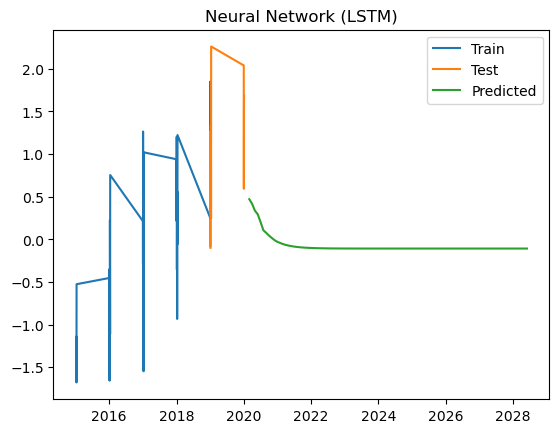

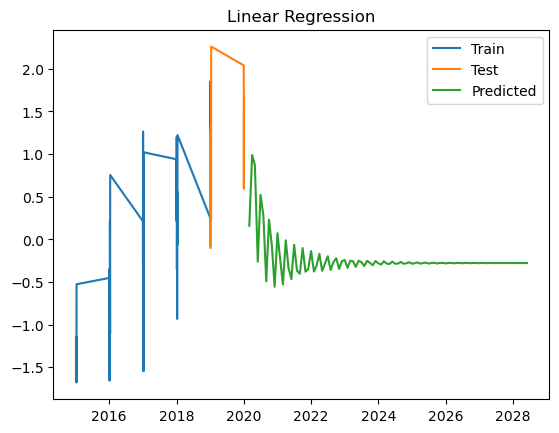

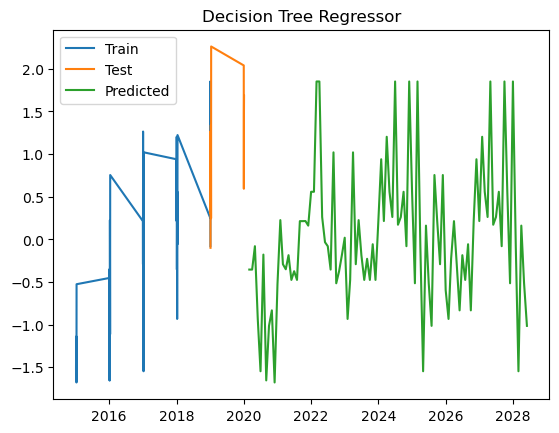

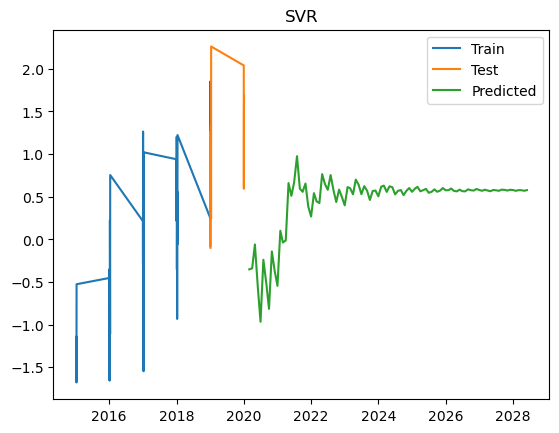

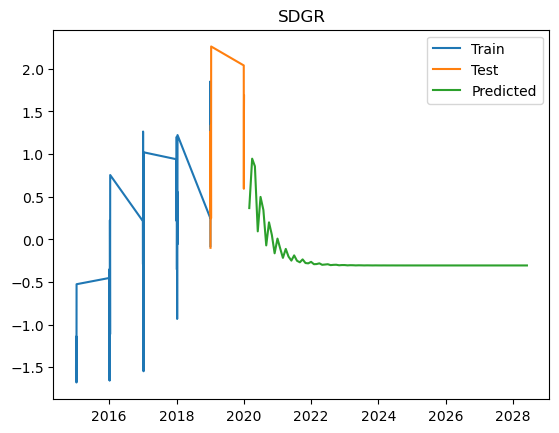

In [44]:
# Function to show the train, test and prediction values
def future_chart(future_target, y_train, y_test, x_date, window, title=''):
    original_target_size = len(y_train) + len(y_test)
    sns.lineplot(x=x_date[window:len(y_train) + window], y=y_train[:,0], label='Train')
    sns.lineplot(x=x_date[len(y_train) + window: original_target_size + window], y=y_test[:,0], label='Test')
    sns.lineplot(x=x_date[original_target_size + window:], y=future_target[original_target_size:,0], label='Predicted')
    plt.title(label=title)
    plt.show()

future_chart(target_model_scaled,  y_train, y_test, all_dates, window, title='Neural Network (LSTM)')
future_chart(target_model_linear_scaled,  y_train, y_test, all_dates, window, title='Linear Regression')
future_chart(target_model_decision_tree_scaled,  y_train, y_test, all_dates, window, title='Decision Tree Regressor')
future_chart(target_model_svr_scaled,  y_train, y_test, all_dates, window, title='SVR')
future_chart(target_model_sdgr_scaled,  y_train, y_test, all_dates, window, title='SDGR')